-------------
```{admonition} Learning Objectives
  - Implement machine learning workflows for spatial prediction using sklearn and rasterio
  - Create supervised and unsupervised land cover classifications from raster data
  - Apply cross-validation and hyperparameter tuning for spatial datasets
  - Handle time series raster data for temporal analysis
  - Use sklearn pipelines for preprocessing and model training

```
--------------


# Spatial Prediction using Machine Learning with Python

## Land Use Classification using Rasterio, Rioxarray & Sklearn

Land cover classification is a fundamental application of machine learning in remote sensing. This tutorial demonstrates how to train ML models using raster data, combining rasterio for data handling, sklearn for machine learning, and custom functions for spatial processing.

### Supervised Classification Workflow

Supervised classification requires training data with known land cover labels. This example uses polygons representing different land cover classes ['water','crop','tree','developed'] and employs sklearn's LabelEncoder to convert text labels to integer categories.

In [1]:
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = gpd.read_file('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg')
labels['lc'] = le.fit(labels.name).transform(labels.name)
print(labels)

        name                                           geometry  lc
0      water  POLYGON ((737544.502 -2795232.772, 737544.502 ...   3
1       crop  POLYGON ((742517.658 -2798160.232, 743046.717 ...   0
2       tree  POLYGON ((742435.36 -2801875.403, 742458.874 -...   2
3  developed  POLYGON ((738903.667 -2811573.845, 738926.586 ...   1


### Building ML Pipelines for Spatial Data

Sklearn pipelines provide a structured approach to data processing and model training. This pipeline includes standard preprocessing steps and a classification algorithm:

 * `StandardScaler`: Normalizes variables by removing mean and scaling to unit variance
 * `PCA`: Reduces dimensionality through Principal Component Analysis
 * `GaussianNB`: Applies Gaussian Naive Bayes for efficient classification

The custom `fit_raster` function extracts training data from raster pixels within labeled polygons, then fits the pipeline.

Class distribution in y_train: {np.int64(0): np.int64(9), np.int64(1): np.int64(3), np.int64(2): np.int64(9), np.int64(3): np.int64(6)}
CV Results: {'mean_fit_time': array([0.00450468, 0.00294876, 0.00425136, 0.00594819, 0.0072583 ,
       0.00601447]), 'std_fit_time': array([0.00048661, 0.00058365, 0.0002507 , 0.00142658, 0.00024235,
       0.0004648 ]), 'mean_score_time': array([0.00398529, 0.00251806, 0.00278139, 0.00458038, 0.00445473,
       0.00499332]), 'std_score_time': array([1.45304203e-03, 4.93645668e-04, 7.42673874e-04, 5.81145287e-04,
       8.11815262e-05, 7.74860382e-06]), 'param_pca__n_components': masked_array(data=[1, 1, 2, 2, 3, 3],
             mask=[False, False, False, False, False, False],
       fill_value=999999), 'param_scaler__with_std': masked_array(data=[True, False, True, False, True, False],
             mask=[False, False, False, False, False, False],
       fill_value=True), 'params': [{'pca__n_components': 1, 'scaler__with_std': True}, {'pca__n_compone

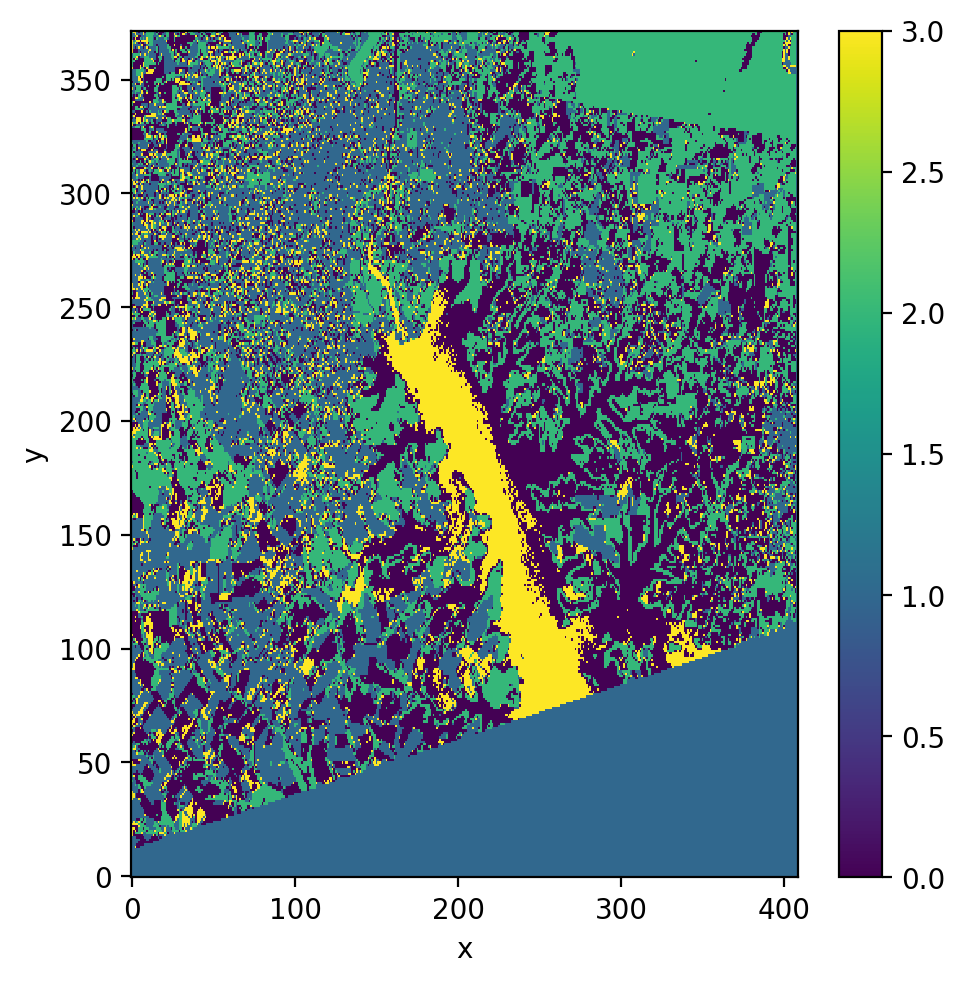

In [3]:
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import xarray as xr
import rioxarray
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import geopandas as gpd

def fit_raster(raster_path, pipeline, labels, col='lc'):
    """Extract training data from raster and fit pipeline."""
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        data = ds.read()  # Shape: (bands, height, width)
        height, width = data.shape[1], data.shape[2]
    
    # Resample to 150m
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        transform = src.rio.transform()
        height, width = src.shape[1], src.shape[2]
    
    # Reshape to (samples, bands)
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    # Extract pixels and labels per polygon
    X_train = []
    y_train = []
    for idx, row in labels.iterrows():
        geom = row.geometry
        label = row[col]
        mask = geometry_mask([geom], (height, width), transform, invert=True)
        X_train.append(X[mask.ravel()])
        y_train.append(np.full(np.sum(mask), label, dtype=int))
    
    # Concatenate training data
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    if len(X_train) == 0:
        raise ValueError("No pixels found under label polygons. Check polygon bounds or CRS.")
    if len(X_train) != len(y_train):
        raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
    if len(X_train) < 10:
        raise ValueError(f"Too few samples ({len(X_train)}) for cross-validation. Increase polygon sizes.")
    
    # Check class distribution
    unique_classes, counts = np.unique(y_train, return_counts=True)
    class_dist = dict(zip(unique_classes, counts))
    print("Class distribution in y_train:", class_dist)
    if len(unique_classes) < 3:
        raise ValueError(f"Only {len(unique_classes)} classes found in y_train. Expected 3. Increase polygon sizes.")
    for cls, count in class_dist.items():
        if count < 5:
            print(f"Warning: Class {cls} has only {count} samples. Consider increasing polygon size.")
    
    # Convert to xarray.Dataset for potential future use
    n_samples, n_features = X_train.shape
    X_da = xr.DataArray(
        X_train,
        coords={'sample': np.arange(n_samples), 'feature': np.arange(n_features)},
        dims=['sample', 'feature']
    )
    y_da = xr.DataArray(
        y_train,
        coords={'sample': np.arange(n_samples)},
        dims=['sample']
    )
    dataset = xr.Dataset({'X': X_da, 'y': y_da})
    
    pipeline.fit(X_train, y_train)
    
    return X, dataset, pipeline

def predict_raster(raster_path, X, pipeline):
    """Predict classes for entire raster."""
    y_pred = pipeline.predict(X)
    
    with rasterio.open(raster_path) as ds:
        profile = ds.profile
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        height, width = src.shape[1], src.shape[2]
    
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(
        y_pred,
        coords={'y': np.arange(height), 'x': np.arange(width)},
        dims=['y', 'x']
    )
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(src.rio.transform())
    
    return y_da

# Load and encode labels
le = LabelEncoder()
labels = gpd.read_file('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg')
labels['lc'] = le.fit_transform(labels.name)

# Ensure labels match raster CRS
raster_path = '../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF'
with rasterio.open(raster_path) as src:
    labels = labels.to_crs(src.crs)

# Define pipeline
pl = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', GaussianNB())
])

# Cross-validation using standard sklearn
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
gridsearch = GridSearchCV(pl, cv=cv, scoring='balanced_accuracy',
                          param_grid={
                              "scaler__with_std": [True, False],
                              "pca__n_components": [1, 2, 3]
                          })

# Plotting setup
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

# Fit and predict
X, dataset, pipe = fit_raster(raster_path, pl, labels, col="lc")

# Use the training data from dataset for grid search
gridsearch.fit(dataset.X.values, dataset.y.values)
print("CV Results:", gridsearch.cv_results_)
print("Best Score:", gridsearch.best_score_)
print("Best Params:", gridsearch.best_params_)

# Set best parameters and refit
pipe.set_params(**gridsearch.best_params_)
pipe.fit(dataset.X.values, dataset.y.values)

# Predict on full raster
y = predict_raster(raster_path, X, pipe)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)
plt.show()

## Hyperparameter Tuning with GridSearchCV

GridSearchCV systematically tests different parameter combinations to find optimal model settings. This example demonstrates tuning PCA components and scaling parameters while using cross-validation to prevent overfitting.

The pipeline parameters are referenced using the format `(step_name)__(parameter_name)`:
- `"scaler__with_std": [True, False]` - tests StandardScaler with/without standard deviation scaling
- `"pca__n_components": [1, 2, 3]` - tests different numbers of principal components

Class distribution in y_train: {np.int64(0): np.int64(9), np.int64(1): np.int64(3), np.int64(2): np.int64(9), np.int64(3): np.int64(6)}
{'mean_fit_time': array([0.01013267, 0.00929427, 0.01005518, 0.01004934, 0.01105571,
       0.01130486]), 'std_fit_time': array([0.00054419, 0.00026321, 0.00050151, 0.0004909 , 0.00049543,
       0.00074792]), 'mean_score_time': array([0.00751567, 0.00654006, 0.00654197, 0.00804842, 0.00605893,
       0.00604582]), 'std_score_time': array([5.07116318e-04, 7.62939453e-06, 7.39097595e-06, 5.03897667e-04,
       5.08785248e-04, 4.88996506e-04]), 'param_pca__n_components': masked_array(data=[1, 1, 2, 2, 3, 3],
             mask=[False, False, False, False, False, False],
       fill_value=999999), 'param_scaler__with_std': masked_array(data=[True, False, True, False, True, False],
             mask=[False, False, False, False, False, False],
       fill_value=True), 'params': [{'pca__n_components': 1, 'scaler__with_std': True}, {'pca__n_components': 1, 'sc

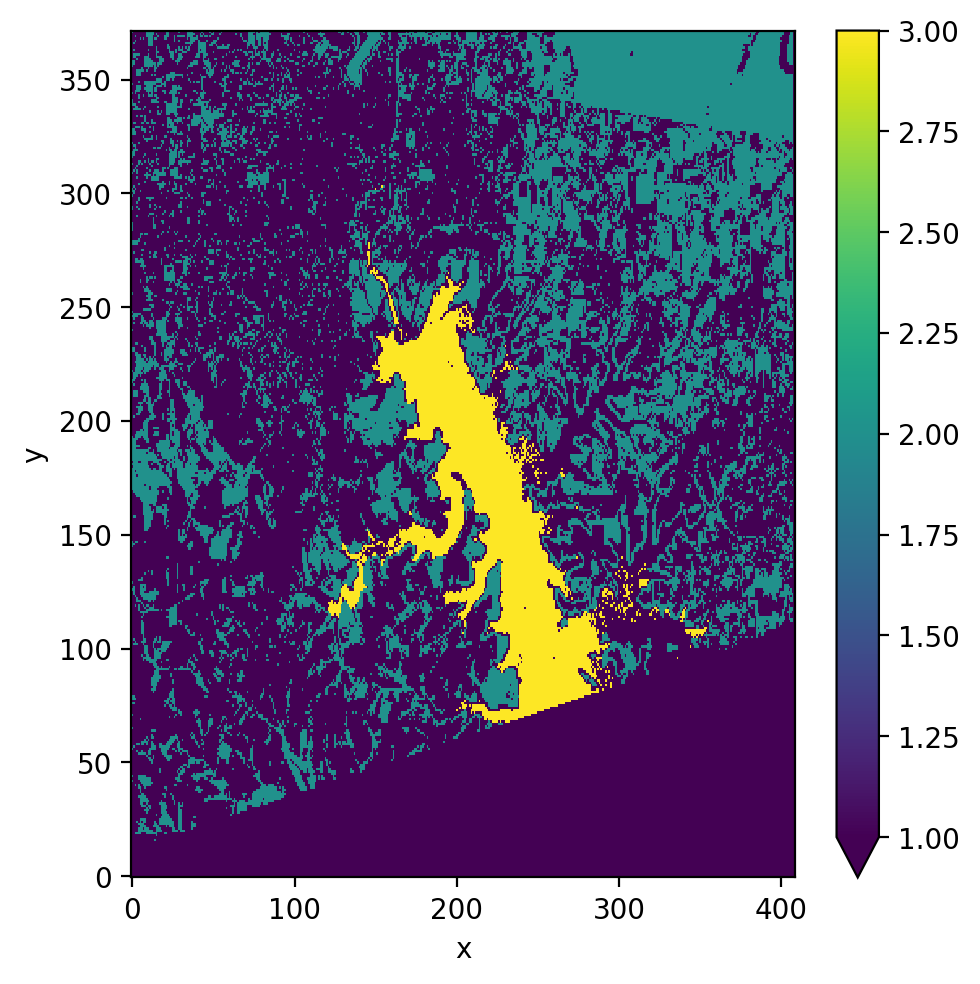

In [4]:
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import xarray as xr
import rioxarray
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn_xarray.model_selection import CrossValidatorWrapper
import matplotlib.pyplot as plt
import geopandas as gpd

def fit_raster(raster_path, pipeline, labels, col='lc'):
    """Extract training data and fit pipeline."""
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        data = ds.read()
        height, width = data.shape[1], data.shape[2]
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        transform = src.rio.transform()
        height, width = src.shape[1], src.shape[2]
    
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    X_train = []
    y_train = []
    for idx, row in labels.iterrows():
        geom = row.geometry
        label = row[col]
        mask = geometry_mask([geom], (height, width), transform, invert=True)
        X_train.append(X[mask.ravel()])
        y_train.append(np.full(np.sum(mask), label, dtype=int))
    
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    if len(X_train) == 0:
        raise ValueError("No pixels found under label polygons. Check polygon bounds or CRS.")
    if len(X_train) != len(y_train):
        raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
    if len(X_train) < 5:
        raise ValueError(f"Too few samples ({len(X_train)}) for cross-validation. Increase polygon sizes.")
    
    # Check class distribution
    unique_classes, counts = np.unique(y_train, return_counts=True)
    print("Class distribution in y_train:", dict(zip(unique_classes, counts)))
    if len(unique_classes) < 3:
        print("Warning: Not all classes (0, 1, 2) are present in y_train. Consider larger polygons.")
    
    # Convert to xarray.Dataset for sklearn_xarray
    n_samples, n_features = X_train.shape
    X_da = xr.DataArray(
        X_train,
        coords={'sample': np.arange(n_samples), 'feature': np.arange(n_features)},
        dims=['sample', 'feature']
    )
    y_da = xr.DataArray(
        y_train,
        coords={'sample': np.arange(n_samples)},
        dims=['sample']
    )
    dataset = xr.Dataset({'X': X_da, 'y': y_da})
    
    pipeline.fit(X_train, y_train)
    
    return X, dataset, pipeline

def predict_raster(raster_path, X, pipeline):
    """Predict classes for entire raster."""
    y_pred = pipeline.predict(X)
    
    with rasterio.open(raster_path) as ds:
        profile = ds.profile
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        height, width = src.shape[1], src.shape[2]
    
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(
        y_pred,
        coords={'y': np.arange(height), 'x': np.arange(width)},
        dims=['y', 'x']
    )
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(src.rio.transform())
    
    return y_da

# Load and encode labels
le = LabelEncoder()
labels = gpd.read_file('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg')
labels['lc'] = le.fit_transform(labels.name)

# Ensure labels match raster CRS
raster_path = '../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF'
with rasterio.open(raster_path) as src:
    labels = labels.to_crs(src.crs)

# Define pipeline
pl = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', GaussianNB())
])

# Cross-validation
cv = CrossValidatorWrapper(StratifiedKFold(n_splits=2), dim='sample')
gridsearch = GridSearchCV(pl, cv=cv, scoring='balanced_accuracy',
                          param_grid={
                              "scaler__with_std": [True, False],
                              "pca__n_components": [1, 2, 3]
                          })

# Plotting setup
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

# Fit and predict
X, dataset, pipe = fit_raster(raster_path, pl, labels, col="lc")
gridsearch.fit(dataset.X, dataset.y)
print(gridsearch.cv_results_)
print(gridsearch.best_score_)
print(gridsearch.best_params_)
pipe.set_params(**gridsearch.best_params_)
y = predict_raster(raster_path, X, pipe)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)
plt.show()

## Handling Missing Data in Remote Sensing

Missing data is common in remote sensing due to clouds, sensor failures, or data processing artifacts. Sklearn's SimpleImputer can handle missing values by replacing them with statistical measures (mean, median, mode).

For Landsat data where missing values are often represented as 0 or already masked as `np.nan`, you can integrate imputation into your pipeline:

```python
from sklearn.impute import SimpleImputer

classifier = Pipeline([
    ("remove_nan", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", KMeans(n_clusters=6, random_state=0)),
])

# For data with 0s as missing values:
src = rxr.open_rasterio(raster_path).rio.write_nodata(0)
src_masked = src.where(src != 0, np.nan)  # Convert 0s to NaN
# Then apply the pipeline with SimpleImputer
```

Other imputation strategies include:
- `strategy="median"` - robust to outliers
- `strategy="most_frequent"` - for categorical data
- `strategy="constant"` - fill with a specified constant value

%%train = np.concatenate(y_train)
    
    # Check lengths
    if len(X_train) != len(y_train):
        raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
    
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    return X, (X_train, y_train), pipeline

def predict_raster(raster_path, X, pipeline):
    """Predict classes for entire raster."""
    y_pred = pipeline.predict(X)
    
    with rasterio.open(raster_path) as ds:
        profile = ds.profile  # Get profile from rasterio dataset
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        height, width = src.shape[1], src.shape[2]
    
    y_pred = y_pred.reshape(height, width)
    
    y_da = xr.DataArray(
        y_pred,
        coords={'y': np.arange(height), 'x': np.arange(width)},
        dims=['y', 'x']
    )
    y_da.rio.write_crs(profile['crs'])  # Set CRS
    y_da.rio.write_transform(src.rio.transform())  # Set transform from resampled src
    
    return y_da

Load and encode labels
le = LabelEncoder()
labels = gpd.read_file('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg')
labels['lc'] = le.fit_transform(labels.name)

Define pipeline
pl = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', GaussianNB())
])

Plotting setup
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

Fit and predict
X, Xy, clf = fit_raster('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF', pl, labels, col="lc")
y = predict_raster('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF', X, clf)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)
plt.show()

### Streamlined Fit and Predict Workflow

The `fit_predict_raster` function combines training and prediction into a single operation, making it convenient for rapid prototyping and testing different classification approaches.

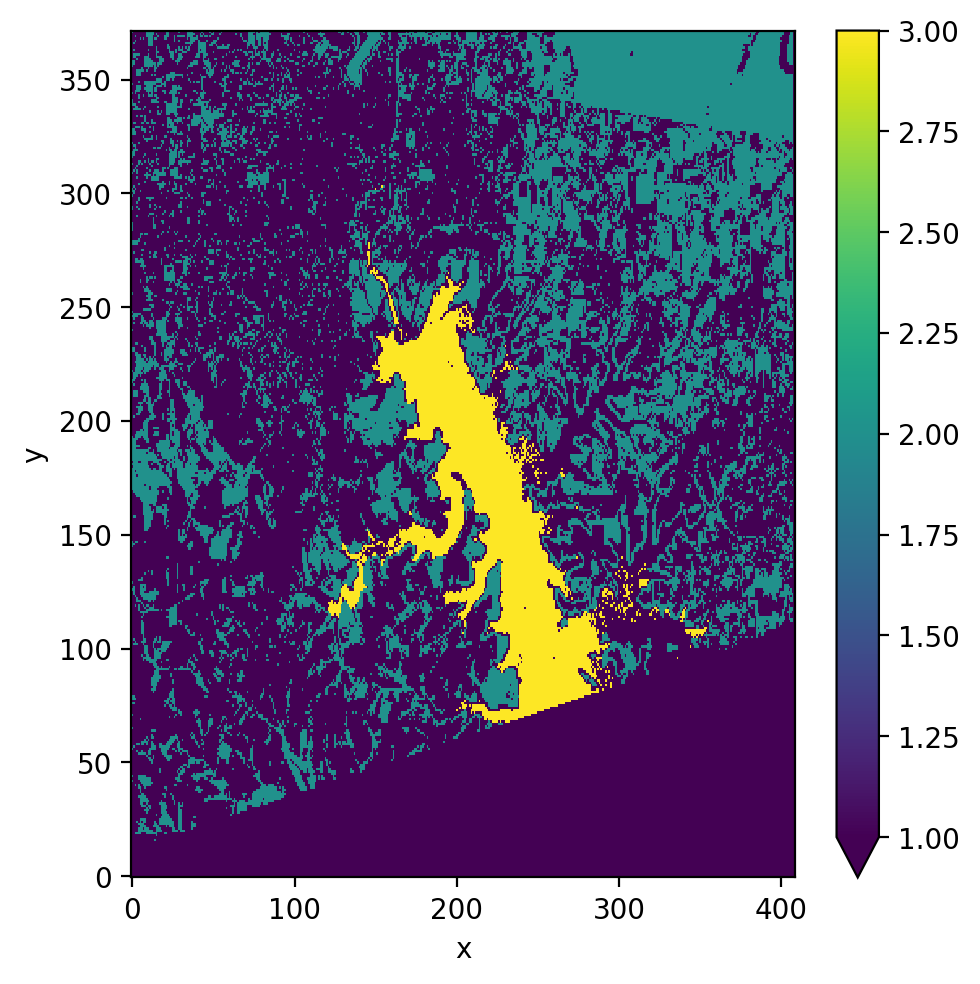

In [5]:
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import xarray as xr
import rioxarray
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import geopandas as gpd

def fit_predict_raster(raster_path, pipeline, labels, col='lc'):
    """Combine fit and predict for supervised classification."""
    # Read and resample raster
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        data = ds.read()  # Shape: (bands, height, width)
        height, width = data.shape[1], data.shape[2]
        profile = ds.profile
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        transform = src.rio.transform()
        height, width = src.shape[1], src.shape[2]
    
    # Reshape to (samples, bands)
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    # Extract pixels and labels per polygon
    X_train = []
    y_train = []
    for idx, row in labels.iterrows():
        geom = row.geometry
        label = row[col]
        mask = geometry_mask([geom], (height, width), transform, invert=True)
        X_train.append(X[mask.ravel()])
        y_train.append(np.full(np.sum(mask), label, dtype=int))
    
    # Concatenate training data
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    # Check lengths
    if len(X_train) != len(y_train):
        raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
    
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X)
    
    # Create output DataArray
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(
        y_pred,
        coords={'y': np.arange(height), 'x': np.arange(width)},
        dims=['y', 'x']
    )
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(src.rio.transform())
    
    return y_da

# Load and encode labels
le = LabelEncoder()
labels = gpd.read_file('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg')
labels['lc'] = le.fit_transform(labels.name)

# Define pipeline
pl = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', GaussianNB())
])

# Plotting setup
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

# Fit and predict
y = fit_predict_raster('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF', pl, labels, col='lc')
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)
plt.show()

### Unsupervised Classification with K-Means

Unsupervised classification identifies natural clusters in the data without requiring training labels. K-means clustering groups pixels with similar spectral characteristics, useful for exploratory analysis or when training data is unavailable. The analyst must later interpret and label the resulting clusters.

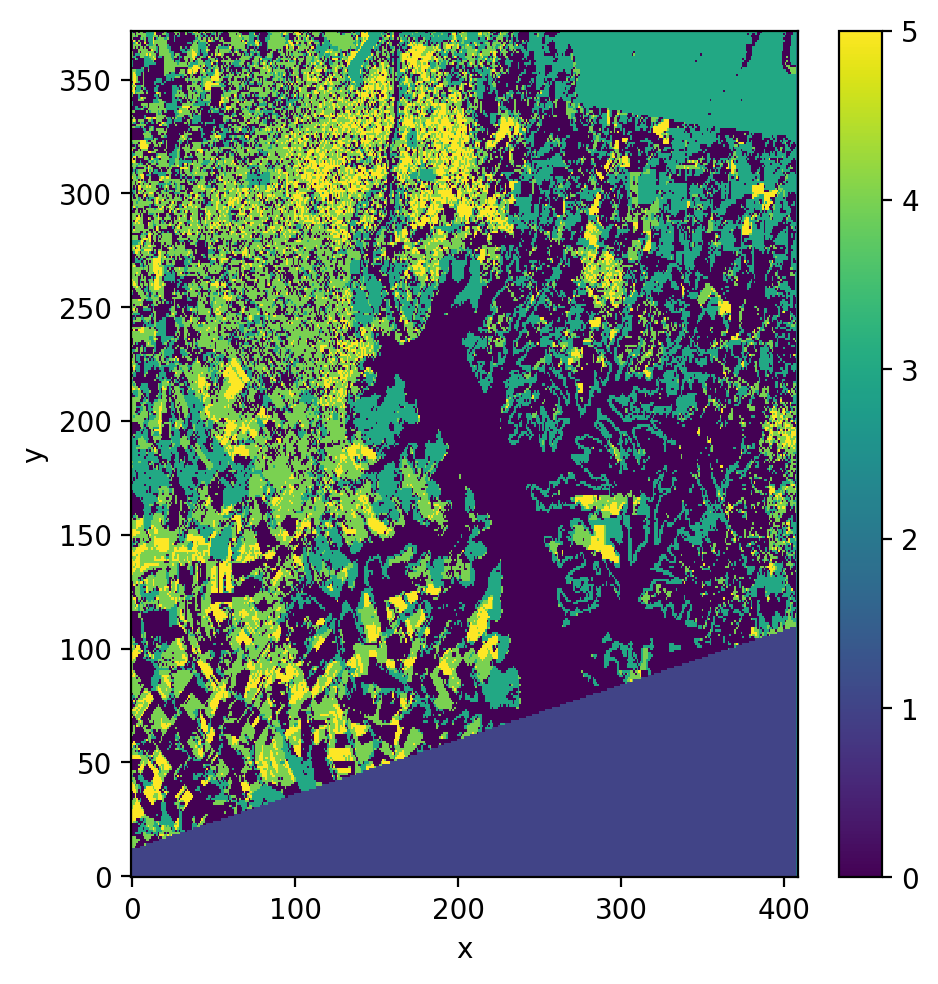

In [6]:
import numpy as np
import rasterio
import xarray as xr
import rioxarray
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def fit_predict_raster(raster_path, pipeline, labels=None, col='lc'):
    """Combine fit and predict for classification (unsupervised or supervised)."""
    # Read and resample raster
    with rasterio.open(raster_path) as ds:
        profile = ds.profile
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        height, width = src.shape[1], src.shape[2]
    
    # Reshape to (samples, bands)
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    if labels is not None:
        # Supervised: Extract pixels and labels per polygon
        transform = src.rio.transform()
        X_train = []
        y_train = []
        for idx, row in labels.iterrows():
            geom = row.geometry
            label = row[col]
            mask = geometry_mask([geom], (height, width), transform, invert=True)
            X_train.append(X[mask.ravel()])
            y_train.append(np.full(np.sum(mask), label, dtype=int))
        
        # Concatenate training data
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        
        # Check lengths
        if len(X_train) != len(y_train):
            raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
        
        # Fit pipeline
        pipeline.fit(X_train, y_train)
    else:
        # Unsupervised: Fit on all data
        pipeline.fit(X)
    
    # Predict
    y_pred = pipeline.predict(X)
    
    # Create output DataArray
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(
        y_pred,
        coords={'y': np.arange(height), 'x': np.arange(width)},
        dims=['y', 'x']
    )
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(src.rio.transform())
    
    return y_da

# Define pipeline
cl = Pipeline([
    ('clf', KMeans(n_clusters=6, random_state=0))
])

# Plotting setup
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

# Fit and predict (unsupervised)
y = fit_predict_raster('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF', cl)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)
plt.show()

## Time Series Classification

Temporal analysis uses multiple acquisition dates to improve classification accuracy and detect changes over time. By stacking rasters along a time dimension using xarray.concat(), you can incorporate temporal dynamics into ML models for more robust predictions.

<xarray.DataArray (y: 372, x: 409)> Size: 1MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 2, ..., 2, 2, 1],
       [1, 1, 1, ..., 2, 2, 1],
       [2, 1, 1, ..., 2, 2, 1]], shape=(372, 409))
Coordinates:
  * y        (y) int64 3kB 0 1 2 3 4 5 6 7 8 ... 364 365 366 367 368 369 370 371
  * x        (x) int64 3kB 0 1 2 3 4 5 6 7 8 ... 401 402 403 404 405 406 407 408


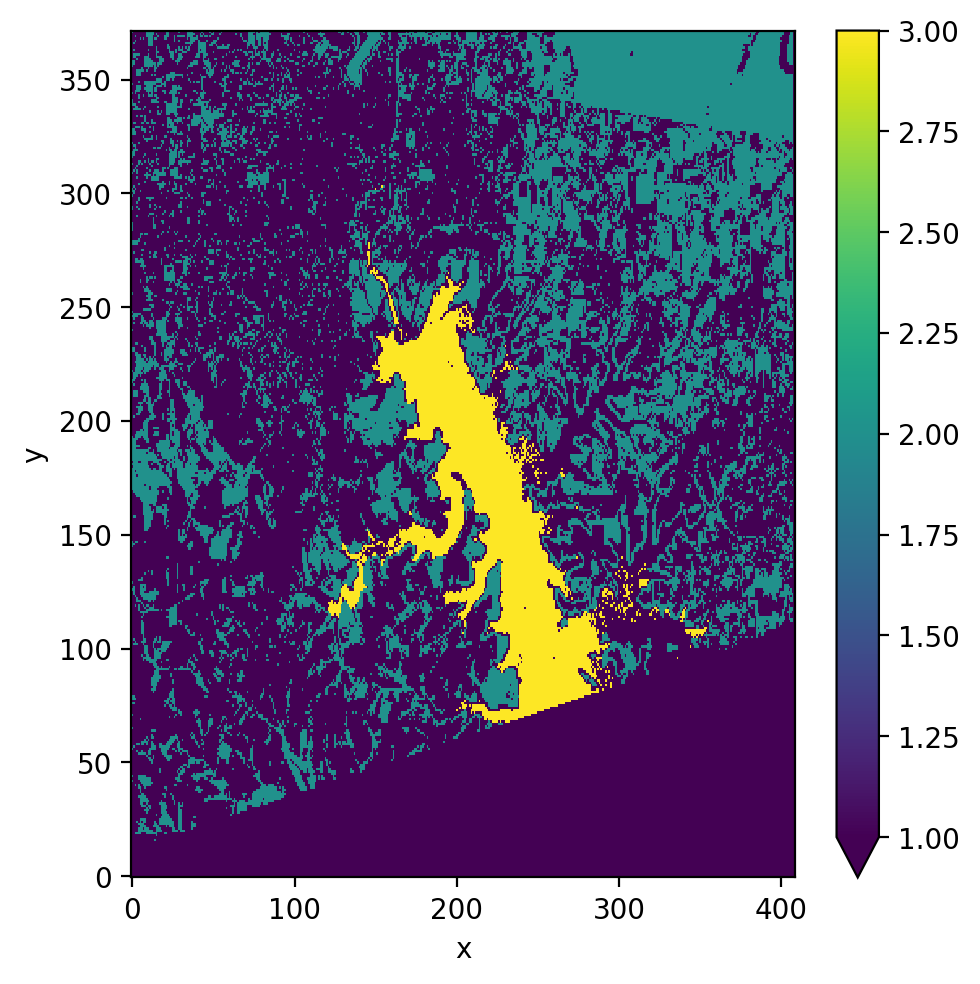

In [7]:
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import xarray as xr
import rioxarray
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import geopandas as gpd

def fit_predict_raster(raster_path, pipeline, labels=None, col='lc'):
    """Combine fit and predict for classification."""
    with rasterio.open(raster_path) as ds:
        profile = ds.profile
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        height, width = src.shape[1], src.shape[2]
        transform = src.rio.transform()
    
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    if labels is not None:
        X_train = []
        y_train = []
        for idx, row in labels.iterrows():
            geom = row.geometry
            label = row[col]
            mask = geometry_mask([geom], (height, width), transform, invert=True)
            X_train.append(X[mask.ravel()])
            y_train.append(np.full(np.sum(mask), label, dtype=int))
        
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        
        if len(X_train) == 0:
            raise ValueError("No pixels found under label polygons. Check polygon bounds or CRS.")
        if len(X_train) != len(y_train):
            raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
        
        pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X)
    
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(
        y_pred,
        coords={'y': np.arange(height), 'x': np.arange(width)},
        dims=['y', 'x']
    )
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(transform)
    
    return y_da

# Load and encode labels
le = LabelEncoder()
labels = gpd.read_file('../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg')
labels['lc'] = le.fit_transform(labels.name)

# Define pipeline
pl = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', GaussianNB())
])

# Plotting setup
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

# Stack rasters
raster_path = '../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF'
with rasterio.open(raster_path) as src:
    crs = src.crs  # Get CRS for reprojection
rasters = [
    rioxarray.open_rasterio(raster_path).rio.reproject(dst_crs=crs, resolution=150),
    rioxarray.open_rasterio(raster_path).rio.reproject(dst_crs=crs, resolution=150)
]
src = xr.concat(rasters, dim='band')

# Save stacked raster to temporary file
stacked_path = '../../pygis/data/stacked_raster.tif'
src.rio.to_raster(stacked_path)

# Ensure labels match raster CRS
labels = labels.to_crs(crs)

# Fit and predict
y = fit_predict_raster(stacked_path, pl, labels, col='lc')
print(y)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)
plt.show()

## Advanced Model Validation with Cross-Validation

Rigorous model evaluation requires techniques like cross-validation to assess performance on unseen data. This approach helps identify overfitting and provides realistic estimates of model performance for spatial prediction tasks.

In [8]:
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import xarray as xr
import rioxarray
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn_xarray.model_selection import CrossValidatorWrapper
import matplotlib.pyplot as plt
import geopandas as gpd

def fit_raster(raster_path, pipeline, labels, col='lc'):
    """Extract training data and fit pipeline."""
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        data = ds.read()
        height, width = data.shape[1], data.shape[2]
    
    with rioxarray.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        transform = src.rio.transform()
        height, width = src.shape[1], src.shape[2]
    
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    X_train = []
    y_train = []
    for idx, row in labels.iterrows():
        geom = row.geometry
        label = row[col]
        mask = geometry_mask([geom], (height, width), transform, invert=True)
        pixels = np.sum(mask)
        print(f"Polygon {idx} ({row['name']}): {pixels} pixels")
        X_train.append(X[mask.ravel()])
        y_train.append(np.full(pixels, label, dtype=int))
    
    X_train = np.concatenate(X_train)
    y_